##### set parent directory

In [1]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Current Directory: /mnt/c/users/rjmay/code/research_ms/alt_distr
Updated Directory: /mnt/c/users/rjmay/code/research_ms


In [2]:
! source "../venv/bin/activate"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import pickle
import time



In [4]:
from modules.multi_bounds_v3 import bounds_class
from modules.Bhatt_knn_func import knn_num_calc
from modules.data_gen import data_gen

In [5]:
PICKLED =True

dim_str = "15" # TODO change me 


In [6]:
file_path = 'sim_data/normal_beta' + dim_str + '.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE

    

if PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst = loaded_objects

Loaded object successfully


### Using the data


In [7]:
dpi = 250

sample_sizes = np.logspace(2, 3.3011, 9 , endpoint = True, dtype = int)


In [8]:
lst = [obj() for obj in bound_obj_lst ]

df = pd.DataFrame(lst, index = sample_sizes)

df.T


/home/rjmay/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rjmay/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/rjmay/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,100,145,211,307,447,650,945,1375,2000
Dp_lower,0.258053,0.250025,0.243858,0.235665,0.229865,0.222435,0.216974,0.211577,0.204703
Dp_upper,0.380000,0.373026,0.367642,0.359471,0.353493,0.345606,0.339569,0.333490,0.325506
Bha_lower,0.055503,0.048325,0.044060,0.040855,0.039043,0.037988,0.037252,0.036694,0.036293
Bha_upper,0.228374,0.214094,0.205015,0.197826,0.193630,0.191121,0.189349,0.187992,0.187003
Bha_knn_lower,0.099330,0.098219,0.097770,0.095806,0.093964,0.134903,0.132340,0.129617,0.126448
Bha_knn_upper,0.298504,0.297240,0.296731,0.294121,0.291644,0.341518,0.338794,0.335836,0.332315
tight_lower,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tight_upper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maha_upper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inf_lower,0.000050,0.000073,0.000115,0.000156,0.000190,0.000168,0.000132,0.000058,0.000031


In [9]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

Bha_knn_u = []
Bha_knn_l = []

inf_l = []
inf_u = []

enDive_l = []
enDive_u = []


for obj in bound_obj_lst:
    a,b = obj.get_bounds_dp()
    dp_l.append(a)
    dp_u.append(b)
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(a)
    Bha_u.append(b)

    
#     a, b = obj.get_bounds_tight()
#     tight_l.append(a)
#     tight_u.append(b)
    
    a, b= obj.get_bounds_Bha_knn()
    Bha_knn_l.append(a)
    Bha_knn_u.append(b)
    
    a,b = obj.get_inf_bounds()
    inf_l.append(a)
    inf_u.append(b)
    
    a,b = obj.get_Bounds_enDive()
    enDive_l.append(a)
    enDive_u.append(b)
    
    

Calculate true values

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import beta
#### I have to code the true values and theoreticals. 

# Define dx and x range
dx = 0.001
x = np.arange(-10, 10 + dx, dx)

# Define the normal distributions
f0 = norm.pdf(x, loc=0, scale=1)
f1 = beta.pdf(x, a=20, b=20)

# Calculate the minimum of f0 and f1
min_f0_f1 = np.minimum(f0, f1)
# Calculate BER as 0.5 * sum(min(f0, f1) * dx)
BER = 0.5 * np.sum(min_f0_f1 * dx)

p = 0.5
q = 0.5
pf0 = p * f0
qf1 = q * f1

# Calculate the function
func = (pf0 - qf1)**2 / (pf0 + qf1)

# Calculate dp using numerical integration (sum and dx)
dp = np.nansum(func) * dx

# Calculate upper and lower bounds
upper = 0.5 - 0.5 * dp
lower = 0.5 - 0.5 * np.sqrt(dp)

theory_Dp = [lower, upper]

func2 = np.sqrt(f0 * f1)
# Calculate BC using numerical integration (sum and dx)
BC = np.nansum(func2) * dx

lower = 0.5 - 0.5 * np.sqrt(1 - BC**2)
upper = 0.5 * BC

theory_bha = [lower, upper]


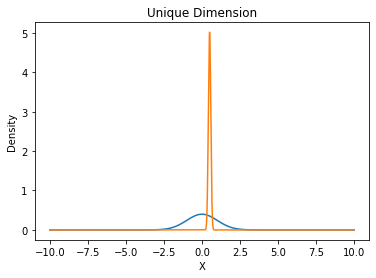

In [11]:
plt.plot(x, f0)
plt.plot(x, f1)
plt.title("Unique Dimension")
plt.xlabel("X")
plt.ylabel("Density")
plt.show()

In [12]:
theory_Dp

[0.06292977858379983, 0.11793924310238751]

In [13]:
BER

0.0726617598018901

True value is     0.07


In [14]:
### this cell helps to fix bugs from not doing the data in here. 
MC_num = len(bound_obj_lst[0])

BER_lst = np.ones(MC_num) * BER



def mse(l1, l2):## numpy lists
    return ((l1 - l2)**2).mean(axis=0)

In [15]:
# cases = len(sample_sizes)

## theoretical MSE
bha_theoretical_l= np.ones(MC_num) * (theory_bha[0])
bha_theoretical_u= np.ones(MC_num) * (theory_bha[1])


dp_theoretical_l= np.ones(MC_num) * theory_Dp[0]
dp_theoretical_u= np.ones(MC_num) * theory_Dp[1]


In [16]:
def mse_v2(true, matrix):
    temp = matrix - true
    temp = temp **2
    return np.mean(temp, axis= 1)
    

### Plotting

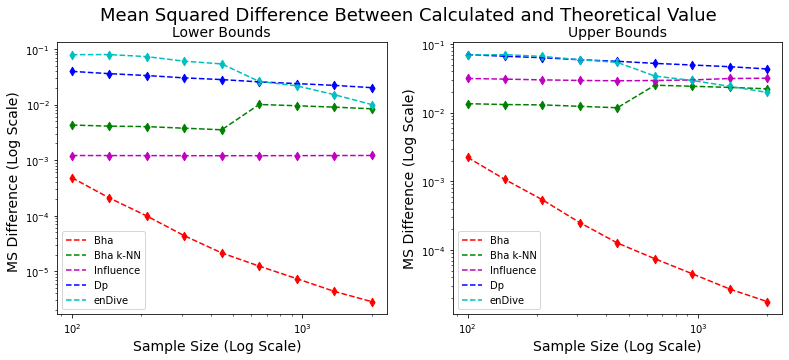

In [17]:
lower_mse_DP =mse_v2(theory_Dp[0], dp_l)
upper_mse_DP = mse_v2(theory_Dp[1], dp_u)

lower_mse_Bha = mse_v2(theory_bha[0], Bha_l)
upper_mse_Bha =mse_v2(theory_bha[1], Bha_u)


lower_mse_Bha_knn = mse_v2(theory_bha[0], Bha_knn_l)
upper_mse_Bha_knn =mse_v2(theory_bha[1], Bha_knn_u)

lower_mse_inf = mse_v2(theory_bha[0], inf_l)
upper_mse_inf = mse_v2(theory_bha[1], inf_u)

lower_mse_enDive = mse_v2(theory_Dp[0], enDive_l)
upper_mse_enDive = mse_v2(theory_Dp[1], enDive_u)


fs =14

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
st = fig.suptitle("Mean Squared Difference Between Calculated and Theoretical Value", fontsize=fs+4)
ax = axes[0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha,'r--', label='Bha')
ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn, color = 'green',linestyle="--",  label = "Bha k-NN")
ax.scatter(sample_sizes, lower_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, lower_mse_inf,  'm--', label='Influence')
ax.scatter(sample_sizes, lower_mse_inf,  color='m', marker='d')

ax.plot(sample_sizes, lower_mse_DP,  'b--', label='Dp')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, lower_mse_enDive,  'c--', label='enDive')
ax.scatter(sample_sizes, lower_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("Lower Bounds", fontsize = fs)



ax.legend()

ax = axes[1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha,'r--', label='Bha')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn, color = 'g',  linestyle  = "--", label = "Bha k-NN")
ax.scatter(sample_sizes, upper_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, upper_mse_inf,  'm--', label='Influence')
ax.scatter(sample_sizes, upper_mse_inf,  color='m', marker='d')


ax.plot(sample_sizes, upper_mse_DP,  'b--', label='Dp')
ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, upper_mse_enDive,  'c--', label='enDive')
ax.scatter(sample_sizes, upper_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale)", fontsize=fs)
ax.set_title("Upper Bounds", fontsize = fs)

ax.legend()



file_name = r"alt_distr/images/normal_beta_MSE" + dim_str+ ".png"
# plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)
plt.show()

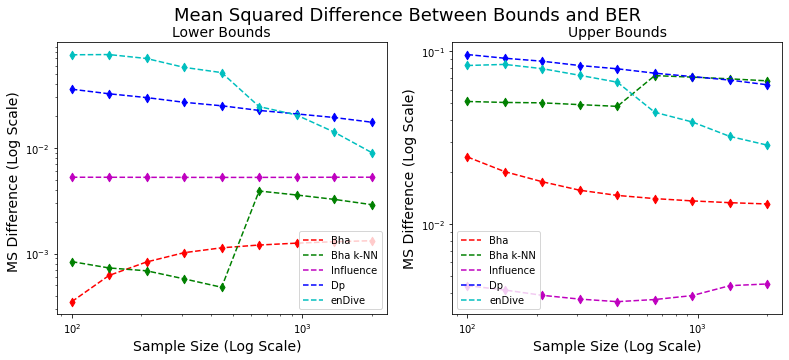

In [18]:
lower_mse_DP_BER =mse_v2(BER, dp_l)
upper_mse_DP_BER = mse_v2(BER, dp_u)

lower_mse_Bha_BER = mse_v2(BER, Bha_l)
upper_mse_Bha_BER =mse_v2(BER, Bha_u)


lower_mse_Bha_knn_BER = mse_v2(BER, Bha_knn_l)
upper_mse_Bha_knn_BER =mse_v2(BER, Bha_knn_u)

lower_mse_inf_BER = mse_v2(BER, inf_l)
upper_mse_inf_BER = mse_v2(BER, inf_u)

lower_mse_enDive_BER = mse_v2(BER, enDive_l)
upper_mse_enDive_BER = mse_v2(BER, enDive_u)

fs =14

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
st = fig.suptitle("Mean Squared Difference Between Bounds and BER", fontsize=fs+4)
ax = axes[0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha_BER,'r--', label='Bha')
ax.scatter(sample_sizes, lower_mse_Bha_BER, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn_BER, color = 'green',linestyle="--",  label = "Bha k-NN")
ax.scatter(sample_sizes, lower_mse_Bha_knn_BER, color = 'g', marker = 'd')

ax.plot(sample_sizes, lower_mse_inf_BER,  'm--', label='Influence')
ax.scatter(sample_sizes, lower_mse_inf_BER,  color='m', marker='d')

ax.plot(sample_sizes, lower_mse_DP_BER,  'b--', label='Dp')
ax.scatter(sample_sizes, lower_mse_DP_BER,  color='b', marker='d')


ax.plot(sample_sizes, lower_mse_enDive_BER,  'c--', label='enDive')
ax.scatter(sample_sizes, lower_mse_enDive_BER,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("Lower Bounds", fontsize = fs)


ax.legend()

ax = axes[1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha_BER,'r--', label='Bha')
ax.scatter(sample_sizes, upper_mse_Bha_BER, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn_BER, color = 'g',  linestyle  = "--", label = "Bha k-NN")
ax.scatter(sample_sizes, upper_mse_Bha_knn_BER, color = 'g', marker = 'd')

ax.plot(sample_sizes, upper_mse_inf_BER,  'm--', label='Influence')
ax.scatter(sample_sizes, upper_mse_inf_BER,  color='m', marker='d')


ax.plot(sample_sizes, upper_mse_DP_BER,  'b--', label='Dp')
ax.scatter(sample_sizes, upper_mse_DP_BER,  color='b', marker='d')


ax.plot(sample_sizes, upper_mse_enDive_BER,  'c--', label='enDive')
ax.scatter(sample_sizes, upper_mse_enDive_BER,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale)", fontsize=fs)
ax.set_title("Upper Bounds", fontsize = fs )

ax.legend()



file_name = r"alt_distr/images/normal_beta_MSE2" + dim_str+ ".png"
# plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)
plt.show()

Bhattacharyya, Bha Knn, influence same theoretically

Dp, enDive

In [19]:
BER

0.0726617598018901

In [20]:
lst = [obj.validity(BER) for obj in bound_obj_lst ]

df_valid = pd.DataFrame(lst, index = sample_sizes)

df_valid


,Dp_lower,Dp_upper,Bha_lower,Bha_upper,Bha_knn_lower,Bha_knn_upper,tight_lower,tight_upper,Maha_upper,inf_lower,inf_upper,enDive_lower,enDive_upper,Dp,Bha,Bha_knn,tight,inf,enDive
100,0.0,1.0,0.98,1.0,0.0050,1.0,NaN,NaN,NaN,1.0,0.0,0.4175,0.6000,0.0,0.98,0.0050,NaN,0.0,0.0175
145,0.0,1.0,1.00,1.0,0.0025,1.0,NaN,NaN,NaN,1.0,0.0,0.4375,0.5900,0.0,1.00,0.0025,NaN,0.0,0.0275
211,0.0,1.0,1.00,1.0,0.0000,1.0,NaN,NaN,NaN,1.0,0.0,0.4325,0.6000,0.0,1.00,0.0000,NaN,0.0,0.0325
307,0.0,1.0,1.00,1.0,0.0000,1.0,NaN,NaN,NaN,1.0,0.0,0.3975,0.6525,0.0,1.00,0.0000,NaN,0.0,0.0500
447,0.0,1.0,1.00,1.0,0.0000,1.0,NaN,NaN,NaN,1.0,0.0,0.4200,0.6600,0.0,1.00,0.0000,NaN,0.0,0.0800
650,0.0,1.0,1.00,1.0,0.0000,1.0,NaN,NaN,NaN,1.0,0.0,0.3750,0.7375,0.0,1.00,0.0000,NaN,0.0,0.1125
945,0.0,1.0,1.00,1.0,0.0000,1.0,NaN,NaN,NaN,1.0,0.0,0.3550,0.7525,0.0,1.00,0.0000,NaN,0.0,0.1075
1375,0.0,1.0,1.00,1.0,0.0000,1.0,NaN,NaN,NaN,1.0,0.0,0.4050,0.7250,0.0,1.00,0.0000,NaN,0.0,0.1300
2000,0.0,1.0,1.00,1.0,0.0000,1.0,NaN,NaN,NaN,1.0,0.0,0.3050,0.8075,0.0,1.00,0.0000,NaN,0.0,0.1125


In [21]:
def add_noise_to_df(df, noise_level=0.01):
    """
    Add random noise to each column in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the data to which noise will be added.
    
    Returns:
    - pandas DataFrame with noise added to each column.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_noisy = df.copy()
    
    # Iterate through each column in the DataFrame
    for col in df.columns:
        # Calculate the range of the data in the column
#         data_range = df[col].max() - df[col].min()
        
        # Generate random noise from a normal distribution
#         noise = np.random.normal(0, noise_level * data_range, len(df[col]))
        noise = np.random.normal(0, noise_level )
#         noise = np.random.uniform(-1 * noise_level, noise_level)
        # Add the noise to the data in the column
        df_noisy[col] = df[col] + noise
    
    return df_noisy


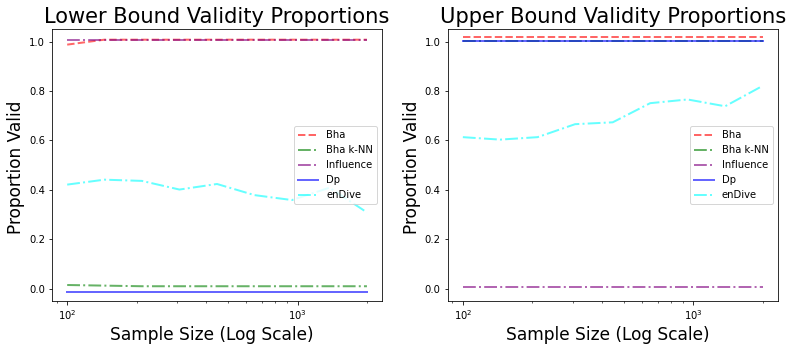

In [22]:
df_noise = add_noise_to_df(df_valid, .008)

fs =17
overlapping = 0.6
lw = 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax = axes[0]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df_noise["Bha_lower"],'r--', label='Bha', alpha = overlapping, linewidth=lw )

ax.plot(df_noise["Bha_knn_lower"],'g-.', label='Bha k-NN', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["inf_lower"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["Dp_lower"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["enDive_lower"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)


# ax.plot(df_valid["tight_lower"],'orange', label='Tight  ')


# ax.plot(sample_sizes, validity_tight_u/ MC_num,  label='Upper Tight Validity ')
# ax.set_xticks(sample_sizes)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df_noise["Bha_upper"],'r--', label='Bha', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["Bha_knn_upper"],'g-.', label='Bha k-NN', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["inf_upper"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth =lw)

ax.plot(df_noise["Dp_upper"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["enDive_upper"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)


# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_ylim(-0.05,1.05)
ax.set_title("Upper Bound Validity Proportions" , fontsize = fs +4)
ax.legend()

# plt.subplots_adjust(left=0.05, right=0.96, bottom=0.1, top=0.90)


file_name = r"alt_distr/images/normal_beta_validity" + dim_str+".png"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)
plt.show()

### Master Figure


In [23]:
lst = [obj.bound_width() for obj in bound_obj_lst ]

bound_width_df = pd.DataFrame(lst, index = sample_sizes)

bound_width_df.head()

,Dp,Bha,Bha_knn,tight,inf,enDive
100,0.121947,0.172871,0.199174,NaN,0.006326,0.021374
145,0.123001,0.165768,0.199021,NaN,0.008142,0.021538
211,0.123784,0.160955,0.198960,NaN,0.010354,0.026401
307,0.123806,0.156972,0.198315,NaN,0.011906,0.040771
447,0.123628,0.154587,0.197680,NaN,0.012952,0.042954


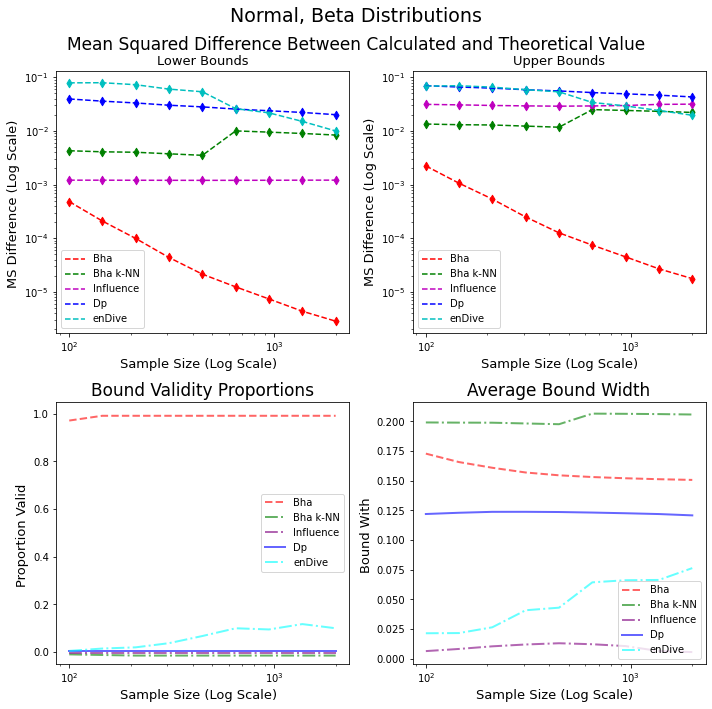

In [24]:

fs =13

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
st = fig.suptitle("Normal, Beta Distributions", fontsize=fs+6)

fig.text(0.5, 0.92, "Mean Squared Difference Between Calculated and Theoretical Value", ha='center', fontsize=fs+4 )

# Manually share y-axis between axes[0][0] and axes[0][1]
axes[0][1].get_shared_y_axes().join(axes[0][0], axes[0][1])


ax = axes[0][0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha,'r--', label='Bha')
ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn, color = 'green',linestyle="--",  label = "Bha k-NN")
ax.scatter(sample_sizes, lower_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, lower_mse_inf,  'm--', label='Influence')
ax.scatter(sample_sizes, lower_mse_inf,  color='m', marker='d')

ax.plot(sample_sizes, lower_mse_DP,  'b--', label='Dp')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, lower_mse_enDive,  'c--', label='enDive')
ax.scatter(sample_sizes, lower_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("Lower Bounds", fontsize = fs)



ax.legend()

ax = axes[0][1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha,'r--', label='Bha')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn, color = 'g',  linestyle  = "--", label = "Bha k-NN")
ax.scatter(sample_sizes, upper_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, upper_mse_inf,  'm--', label='Influence')
ax.scatter(sample_sizes, upper_mse_inf,  color='m', marker='d')


ax.plot(sample_sizes, upper_mse_DP,  'b--', label='Dp')
ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, upper_mse_enDive,  'c--', label='enDive')
ax.scatter(sample_sizes, upper_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale)", fontsize=fs)
ax.set_title("Upper Bounds", fontsize = fs)
ax.legend()


ax = axes[1][0]
ax1 = ax

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df_noise["Bha"],'r--', label='Bha', alpha = overlapping, linewidth=lw )
ax.plot(df_noise["Bha_knn"],'g-.', label='Bha k-NN', alpha = overlapping, linewidth = lw)
ax.plot(df_noise["inf"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth = lw)
ax.plot(df_noise["Dp"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)
ax.plot(df_noise["enDive"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)

# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_ylim(-0.05,1.05)
ax.set_title("Bound Validity Proportions" , fontsize = fs +4)
ax.legend()



ax = axes[1][1]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(bound_width_df["Bha"],'r--', label='Bha', alpha = overlapping, linewidth=lw )
ax.plot(bound_width_df["Bha_knn"],'g-.', label='Bha k-NN', alpha = overlapping, linewidth = lw)
ax.plot(bound_width_df["inf"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth = lw)
ax.plot(bound_width_df["Dp"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)
ax.plot(bound_width_df["enDive"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)

# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Bound With ", fontsize=fs)
# ax.set_ylim(0.0, 0.3)
ax.set_title("Average Bound Width" , fontsize = fs +4)
ax.legend()


fig.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the common title



file_name = r"alt_distr/images/normal_beta_master" + dim_str + ".png"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)
plt.show()